# Section 5. Prediction on Risks

In this section, we are going to use the word2vec model trainned by the corpus to performing the word embedding for the texts we are interested in.

In [1]:
import numpy as np
import pandas as pd
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings("ignore")

## 5.1 Labeled Dataset

### 5.1.1 Insight

In [162]:
risk_df = pd.read_csv("../Section 3 - Risk Factor Organizing/risk.csv")
risk_df.head()

,adsh,Risk Factors,Label 1,Label 1 - details,Label 2,Label 2 - details
0,0000036966-23-000016,Risks Related to the Pending TD Merger,strategy risk,Merger & Acquisition,NaN,NaN
1,0000036966-23-000016,Receipt of regulatory approvals for the Pendin...,strategy risk,NaN,NaN,NaN
2,0000036966-23-000016,"Regulatory approvals may not be received, have...",legal and regulatory risk,NaN,NaN,NaN
3,0000036966-23-000016,The TD Merger Agreement may be terminated in a...,strategy risk,Merger & Acquisition,NaN,NaN
4,0000036966-23-000016,Failure to complete the Pending TD Merger coul...,market risk,Stock Price Fluctuate,NaN,NaN


In [163]:
_22FY10KFile_df = pd.read_csv("../Section 1 - Datasets Downloads and Preparation/22FY10KFile.csv")
_22FY10KFile_df.head()

,adsh,cik,name,sic,countryba,stprba,cityba,zipba,bas1,bas2,...,accepted,prevrpt,detail,instance,nciks,aciks,SIC Code,Office,Industry Title,filing_url
0,0001412408-22-000019,1412408,"PHREESIA, INC.",7389.0,US,NC,RALEIGH,27601,434 FAYETTEVILLE ST.,SUITE 1400,...,2022-03-31 16:03:00.0,0,1,phr-20220131_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/141240...
1,0001428336-22-000009,1428336,"HEALTHEQUITY, INC.",7389.0,US,UT,DRAPER,84020,15 WEST SCENIC POINTE DRIVE,SUITE 100,...,2022-03-31 16:04:00.0,0,1,hqy-20220131_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/142833...
2,0001199835-22-000283,1079282,"RIVULET MEDIA, INC.",7389.0,US,AZ,GILBERT,85296,"1206 EAST WARNER ROAD, SUITE 101-I",NaN,...,2022-05-12 20:06:00.0,0,1,rivu-10k_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/107928...
3,0001558891-22-000031,1726079,"TIPMEFAST, INC.",7389.0,IL,NaN,ZIHRON YA'AKOV,30950,HASHUMURA ST 1,NaN,...,2022-05-13 11:56:00.0,0,1,tpmf-20211231_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/172607...
4,0001493152-22-009370,1022899,"PROTAGENIC THERAPEUTICS, INC.NEW",7389.0,US,NY,NEW YORK,10010,149 FIFTH AVENUE,SUITE 500,...,2022-04-07 17:09:00.0,0,1,form10-k_htm.xml,1,NaN,7389,Office of Trade & Services,"SERVICES-BUSINESS SERVICES, NEC",https://www.sec.gov/Archives/edgar/data/102289...


In [164]:
risk_df = pd.merge(risk_df, _22FY10KFile_df, left_on = "adsh", right_on = "adsh")
risk_df.head()

,adsh,Risk Factors,Label 1,Label 1 - details,Label 2,Label 2 - details,cik,name,sic,countryba,...,accepted,prevrpt,detail,instance,nciks,aciks,SIC Code,Office,Industry Title,filing_url
0,0000036966-23-000016,Risks Related to the Pending TD Merger,strategy risk,Merger & Acquisition,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...
1,0000036966-23-000016,Receipt of regulatory approvals for the Pendin...,strategy risk,NaN,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...
2,0000036966-23-000016,"Regulatory approvals may not be received, have...",legal and regulatory risk,NaN,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...
3,0000036966-23-000016,The TD Merger Agreement may be terminated in a...,strategy risk,Merger & Acquisition,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...
4,0000036966-23-000016,Failure to complete the Pending TD Merger coul...,market risk,Stock Price Fluctuate,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,2023-03-01 06:07:00.0,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...


In [165]:
risk_df = risk_df[risk_df["Label 2"].isnull()]

### 5.1.2 EDA

<Axes: title={'center': 'Number of Risk Factors'}, xlabel='Label 1'>

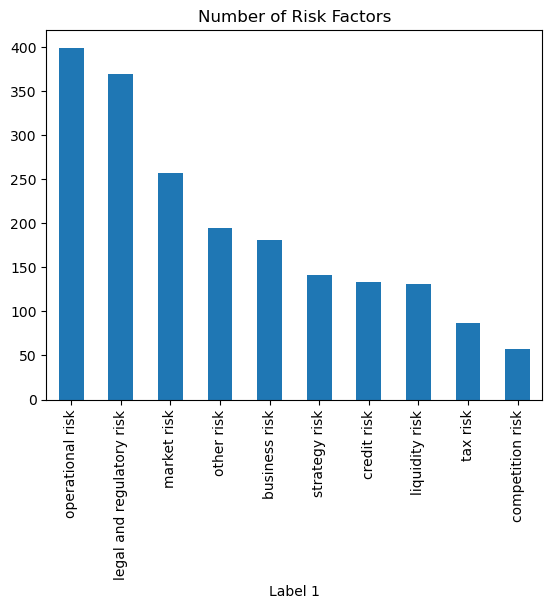

In [6]:
risk_df["Label 1"].value_counts().plot(kind="bar", title="Number of Risk Factors")

<Axes: title={'center': 'File Status'}, xlabel='afs'>

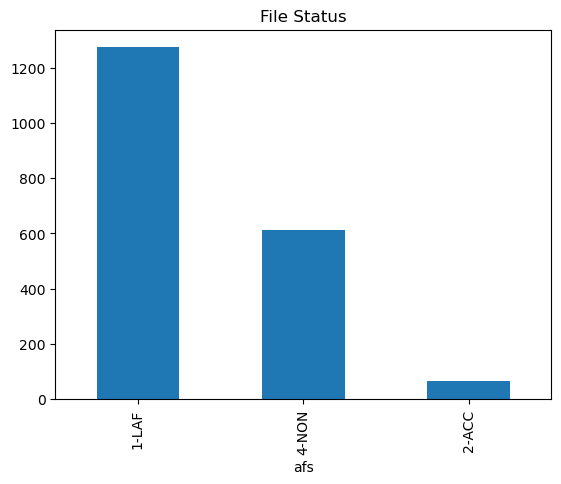

In [7]:
risk_df["afs"].value_counts().plot(kind="bar", title="File Status")

---

## 5.2 Corpus Pre-processing

### 5.2.1 Risk Factors Corpus
 We have build up a corpus based on the text collected from SEC website. Now, we are going to attempt it for our word2vec model.
1. Read in the corpus dataset

In [8]:
riskCorpus_df = pd.read_excel("../Section 4 - Corpus/Corpus Extraction/Part 1/Corpus1-t.xlsx")
riskCorpus_df.head()

,adsh,Risk Text
0,0000004904-23-000011,GENERAL RISKS OF REGULATED OPERATIONS\nAEP may...
1,0000007332-23-000005,"Natural gas, oil and NGL prices and basis diff..."
2,0000008670-22-000038,LEGAL AND COMPLIANCE RISKS\nFailure to comply ...
3,0000010254-23-000058,Marketing and Customers\nTransportation and Ga...
4,0000014272-23-000046,Government Regulation\nSources and Availabilit...


In [9]:
riskCorpus_lst = riskCorpus_df["Risk Text"].tolist()
print("The first 5 records in the file are shown below: \n", riskCorpus_lst[:5], "\n")
print("There are", len(riskCorpus_lst), "records in the file.")

The first 5 records in the file are shown below: 
 ['GENERAL RISKS OF REGULATED OPERATIONS\nAEP may not be able to recover the costs of substantial planned investment in capital improvements and additions. (Applies to all Registrants)\nRegulated electric revenues and earnings are dependent on federal and state regulation that may limit AEP’s ability to recover costs and other amounts. (Applies to all Registrants)\nAEP’s transmission investment strategy and execution are dependent on federal and state regulatory policy. (Applies to all Registrants)\nCertain elements of AEP’s transmission formula rates have been challenged, which could result in lowered rates and/or refunds of amounts previously collected and thus have an adverse effect on AEP’s business, financial condition, results of operations and cash flows. (Applies to all Registrants other than AEP Texas)\nAEP faces risks related to project siting, financing, construction, permitting, governmental approvals and the negotiation of 

2. To train a word2vec model, we firstly need to tokenize the corpus. Basically, we only focus on the English words without any punctuations and remove the stopwords. Also, we stem the tokens.

In [8]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append("risk")
stopwords.append("risks")
print ("We use " + str(len(stopwords)) + " stop-words from nltk library.")
print (stopwords[:10])

We use 181 stop-words from nltk library.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [9]:
from nltk.stem.snowball import SnowballStemmer
# from nltk.stem import WordNetLemmatizer 
stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    tokens = []
    # exclude stop words and tokenize the document, generate a list of string 
    for word in nltk.word_tokenize(text):
        if word.lower() not in stopwords:
            tokens.append(word.lower())

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if token.isalpha():
            filtered_tokens.append(token)
            
#     # stemming
#     stems = [stemmer.stem(t) for t in filtered_tokens]

    return filtered_tokens
#     return stems

3. Now, we output a few results of records in the corpus.

In [10]:
corpusToken_lst = []
for i in range(0,len(riskCorpus_df)):
    corpusToken_lst.append(tokenization_and_stemming(riskCorpus_lst[i]))
print("The token of the first 5 text are shown below: \n", corpusToken_lst[:5], "\n")
print("There are", len(corpusToken_lst), "elements in the token list.")

NameError: name 'riskCorpus_df' is not defined

### 5.2.2 wikipedia corpus
We have noticed that the risk facotrs corpus might be not large enough for training a word2vec model, so we have also build up a wikipedia corpus in previous section. We are going to use it and compare with the model trained by risk facotrs corpus.


In [11]:
from nltk import sent_tokenize
def split_into_sentences(text):
    sentences = sent_tokenize(text)
    return sentences

In [12]:
import os
folderPath = "D:/EN-Wiki/wiki-seg/"
fileName_lst = os.listdir(folderPath)
filePair_dict = {} # filePair stores the file name and the corresponding file text.
for fileName in fileName_lst:
    # encode each document
    filePath = str(folderPath) + str(fileName)
    with open(filePath, 'r', encoding='utf-8') as file:
        fileText = file.read()
    filePair_dict[fileName] = fileText

In [13]:
wikiToken_lst = []
for key, value in  filePair_dict.items():
    wikiToken_lst.append(tokenization_and_stemming(value))
print("The tokens in the first wikipedia documents are shown below: \n", wikiToken_lst[:1])

In [14]:
wikiToken_lst[:1]

[['anarchism',
  'political',
  'philosophy',
  'movement',
  'skeptical',
  'justifications',
  'authority',
  'seeks',
  'abolish',
  'institutions',
  'claims',
  'maintain',
  'unnecessary',
  'coercion',
  'hierarchy',
  'typically',
  'including',
  'nation',
  'states',
  'capitalism',
  'anarchism',
  'advocates',
  'replacement',
  'state',
  'stateless',
  'societies',
  'voluntary',
  'free',
  'associations',
  'historically',
  'left',
  'wing',
  'movement',
  'reading',
  'anarchism',
  'placed',
  'farthest',
  'left',
  'political',
  'spectrum',
  'usually',
  'described',
  'libertarian',
  'wing',
  'socialist',
  'movement',
  'libertarian',
  'socialism',
  'humans',
  'lived',
  'societies',
  'without',
  'formal',
  'hierarchies',
  'long',
  'establishment',
  'states',
  'realms',
  'empires',
  'rise',
  'organised',
  'hierarchical',
  'bodies',
  'scepticism',
  'toward',
  'authority',
  'also',
  'rose',
  'although',
  'traces',
  'anarchist',
  'ideas'

## 5.3 Word2vec Model
### 5.3.1 Train word2vec model by corpus
After processing the corpus, we start to train the word2vec model.

In [16]:
import gensim
from gensim.models import Word2Vec

w2v_model = Word2Vec(wikiToken_lst, vector_size = 300, window = 10, epochs = 10, min_count = 50)

### 5.3.2 Model visualization

In [17]:
from sklearn.decomposition import PCA

X = w2v_model.wv[w2v_model.wv.key_to_index]
pca = PCA(n_components = 2)
result = pca.fit_transform(X)

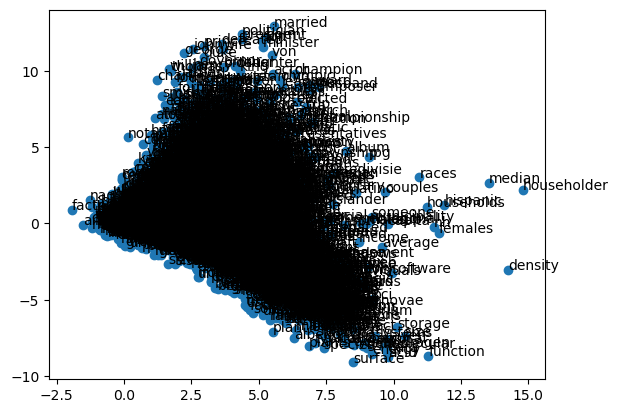

In [18]:
import matplotlib.pyplot as plt

plt.scatter(result[:,0], result[:, 1])
words = list(w2v_model.wv.key_to_index)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i,0], result[i,1]))
plt.show()

### 5.3.3 Apply word2vec model on labeled dataset

We firstly need to generate a tf-idf matrix for the risk factors in labeled dataset. This tf-idf matrix would be used in transforming the word vector to a sentence vector.

In [19]:
risk_lst = risk_df["Risk Factors"].tolist()

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_TFIDF_matrix(token_lst):
    text_lst = [' '.join(words) for words in token_lst]
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(text_lst)
    featureNames = vectorizer.get_feature_names_out()
    dense_matrix = tfidf_matrix.todense()
    return featureNames, dense_matrix

In [21]:
riskToken_lst = []
for i in range(0,len(risk_df)):
    riskToken_lst.append(tokenization_and_stemming(risk_lst[i]))
print("The token of the first 5 text are shown below: \n", riskToken_lst[:5], "\n")
print("There are", len(riskToken_lst), "elements in the token list.")

The token of the first 5 text are shown below: 
 [['related', 'pending', 'td', 'merger'], ['receipt', 'regulatory', 'approvals', 'pending', 'td', 'merger', 'taken', 'longer', 'originally', 'anticipated', 'td', 'expect', 'necessary', 'regulatory', 'approvals', 'received', 'time', 'complete', 'pending', 'td', 'merger', 'current', 'outside', 'date', 'may'], ['regulatory', 'approvals', 'may', 'received', 'taken', 'longer', 'expected', 'may', 'impose', 'conditions', 'presently', 'anticipated'], ['td', 'merger', 'agreement', 'may', 'terminated', 'accordance', 'terms', 'pending', 'td', 'merger', 'may', 'completed'], ['failure', 'complete', 'pending', 'td', 'merger', 'could', 'negatively', 'impact', 'stock', 'price', 'result', 'litigation', 'result', 'significant', 'dilution', 'due', 'terms', 'series', 'g', 'preferred', 'stock', 'issued', 'td']] 

There are 1950 elements in the token list.


In [22]:
featureNames, tfidf_matrix = get_TFIDF_matrix(riskToken_lst)
print ("In total, there are " + str(tfidf_matrix.shape[0]) + \
      " records and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 1950 records and 2763 terms.


Now, we apply the word2vec model on the risk factors text. For each token in a record, we have a correspongding vector by using the word2vec model. However, what we want to use for prediction is actually a group of words acquired from a sentence. Therefore, we want to use all word vectors in a record to generate a sentence vector. To achieve this, we use the tf-idf of each word we calculated previously as a weight to calculate the weighted average of all word vectors in a sentence as a sentence vector.

In [27]:
avgVector_lst = []
r = 0
for token_lst in riskToken_lst:
    vector_lst = []
    for token in token_lst:
        if token in w2v_model.wv:
            
            word_idx = np.where(featureNames == token)[0][0] if token in featureNames else 0
            tfidf = tfidf_matrix[r, word_idx]
            vector_lst.append(w2v_model.wv.get_vector(token)*tfidf)
            
    if not vector_lst:
        avgVector_lst.append([0]*300)
    else:
        avgVector_lst.append((sum(vector_lst) / len(vector_lst)).tolist())
    r+=1        
print("The sentence vector is in shape of", len(avgVector_lst),"*", len(avgVector_lst[0]))

The sentence vector is in shape of 1950 * 300


In [28]:
def find_zero_rows(matrix):
    zero_rows = []

    for i, row in enumerate(matrix):
        if all(element == 0 for element in row):
            zero_rows.append(i)

    return zero_rows

find_zero_rows(avgVector_lst)

[160, 311, 315, 735, 736, 746, 1370]

## 5.4 Models for Prediction
### 5.4.1 Generate a Target Label
Beacause of the labeled dataset is not large enough for a multi-classification task, we have to perform a binary classification on this dataset. Therefore, the first step is to determine the risk that we are interested in and generate the corresponding label as a target variable that we are going to predict. Here, we define a function and use "legal and regulatory risk" as an example to train the model, make a classification and evaluation.

In [166]:
def generate_target_risk(riskName, df):
    df['Target Risk'] = df['Label 1'].apply(lambda x: 1 if x == riskName else 0)
    return df

In [167]:
lrrRisk_df = generate_target_risk(riskName="legal and regulatory risk", df=risk_df)
lrrRisk_df.head()

,adsh,Risk Factors,Label 1,Label 1 - details,Label 2,Label 2 - details,cik,name,sic,countryba,...,prevrpt,detail,instance,nciks,aciks,SIC Code,Office,Industry Title,filing_url,Target Risk
0,0000036966-23-000016,Risks Related to the Pending TD Merger,strategy risk,Merger & Acquisition,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,0
1,0000036966-23-000016,Receipt of regulatory approvals for the Pendin...,strategy risk,NaN,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,0
2,0000036966-23-000016,"Regulatory approvals may not be received, have...",legal and regulatory risk,NaN,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,1
3,0000036966-23-000016,The TD Merger Agreement may be terminated in a...,strategy risk,Merger & Acquisition,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,0
4,0000036966-23-000016,Failure to complete the Pending TD Merger coul...,market risk,Stock Price Fluctuate,NaN,NaN,36966,FIRST HORIZON CORP,6021.0,US,...,0,1,fhn-20221231_htm.xml,1,NaN,6021,Office of Finance,NATIONAL COMMERCIAL BANKS,https://www.sec.gov/Archives/edgar/data/36966/...,0


<Axes: title={'center': 'File Status'}, xlabel='Label 1'>

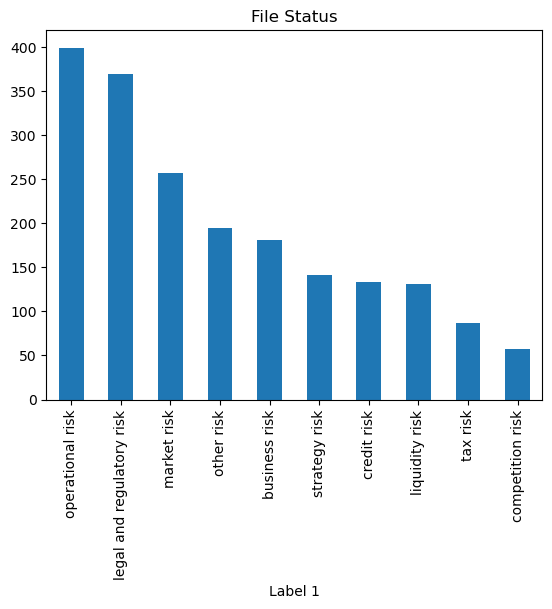

In [253]:
risk_df["Label 1"].value_counts().plot(kind="bar", title="File Status")

<Axes: title={'center': 'File Status'}, xlabel='Target Risk'>

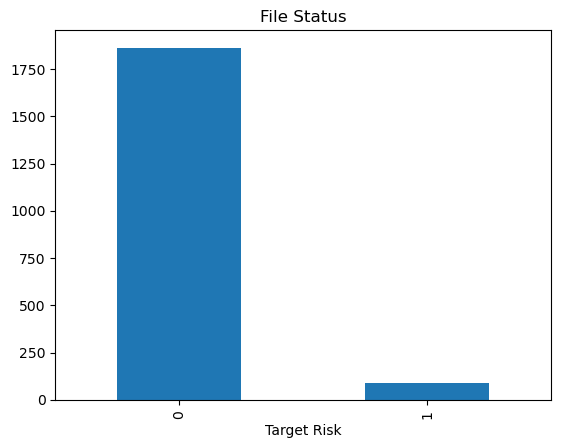

In [255]:
lrrRisk_df["Target Risk"].value_counts().plot(kind="bar", title="File Status")

### 5.4.2 Split the dataset

We define the sentence vector as X and target risk as y and then split the dataset with train size of 0.7.

In [168]:
X = np.array(avgVector_lst)
y = risk_df["Target Risk"].values

In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123, stratify = y)

### 5.4.3 Train models for prediction
Here, we train 3 different models to predict whether a risk subject text is a legal and regulatory risk.
1. Logistic Regression Model:

In [170]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
LR_clf = LogisticRegression()
LR_clf = LR_clf.fit(X_train, y_train)
y_pred = LR_clf.predict(X_test)
print("The accuracy of the logistic model is: \n", accuracy_score(y_test, y_pred))

The accuracy of the logistic model is: 
 0.852991452991453


2. Random Forest Model:

In [171]:
from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(random_state = 123)
RF_clf = RF_clf.fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)
print("The accuracy of the random forest model is: \n", accuracy_score(y_test, y_pred))

The accuracy of the random forest model is: 
 0.8752136752136752


3. Dense Layer Model:

In [173]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, activation="relu"))
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.fit(X_train, y_train, batch_size=256, epochs=200, verbose=2, validation_data=(X_test, y_test))

Epoch 1/200
6/6 - 0s - loss: 6.5543 - acc: 0.0425 - val_loss: 2.6344 - val_acc: 0.2308 - 421ms/epoch - 70ms/step
Epoch 2/200
6/6 - 0s - loss: 1.7535 - acc: 0.2938 - val_loss: 0.9225 - val_acc: 0.3453 - 45ms/epoch - 8ms/step
Epoch 3/200
6/6 - 0s - loss: 0.8032 - acc: 0.4066 - val_loss: 0.7049 - val_acc: 0.5726 - 42ms/epoch - 7ms/step
Epoch 4/200
6/6 - 0s - loss: 0.6346 - acc: 0.6777 - val_loss: 0.5581 - val_acc: 0.8274 - 47ms/epoch - 8ms/step
Epoch 5/200
6/6 - 0s - loss: 0.4920 - acc: 0.8198 - val_loss: 0.5171 - val_acc: 0.8359 - 48ms/epoch - 8ms/step
Epoch 6/200
6/6 - 0s - loss: 0.5433 - acc: 0.8176 - val_loss: 0.7584 - val_acc: 0.8308 - 47ms/epoch - 8ms/step
Epoch 7/200
6/6 - 0s - loss: 0.4733 - acc: 0.8190 - val_loss: 0.4441 - val_acc: 0.8359 - 44ms/epoch - 7ms/step
Epoch 8/200
6/6 - 0s - loss: 0.4352 - acc: 0.8220 - val_loss: 0.4608 - val_acc: 0.8376 - 44ms/epoch - 7ms/step
Epoch 9/200
6/6 - 0s - loss: 0.4426 - acc: 0.8256 - val_loss: 0.4489 - val_acc: 0.8359 - 40ms/epoch - 7ms/step

Epoch 75/200
6/6 - 0s - loss: 0.3761 - acc: 0.8491 - val_loss: 0.5706 - val_acc: 0.8564 - 39ms/epoch - 6ms/step
Epoch 76/200
6/6 - 0s - loss: 0.3757 - acc: 0.8520 - val_loss: 0.5874 - val_acc: 0.8581 - 45ms/epoch - 7ms/step
Epoch 77/200
6/6 - 0s - loss: 0.3749 - acc: 0.8491 - val_loss: 0.6026 - val_acc: 0.8581 - 40ms/epoch - 7ms/step
Epoch 78/200
6/6 - 0s - loss: 0.3748 - acc: 0.8520 - val_loss: 0.5869 - val_acc: 0.8598 - 43ms/epoch - 7ms/step
Epoch 79/200
6/6 - 0s - loss: 0.3788 - acc: 0.8527 - val_loss: 0.4676 - val_acc: 0.8598 - 40ms/epoch - 7ms/step
Epoch 80/200
6/6 - 0s - loss: 0.4501 - acc: 0.8557 - val_loss: 0.5341 - val_acc: 0.8342 - 41ms/epoch - 7ms/step
Epoch 81/200
6/6 - 0s - loss: 0.4804 - acc: 0.8469 - val_loss: 0.5152 - val_acc: 0.8513 - 43ms/epoch - 7ms/step
Epoch 82/200
6/6 - 0s - loss: 0.4220 - acc: 0.8681 - val_loss: 0.5050 - val_acc: 0.8615 - 38ms/epoch - 6ms/step
Epoch 83/200
6/6 - 0s - loss: 0.4119 - acc: 0.8484 - val_loss: 0.7360 - val_acc: 0.8530 - 47ms/epoch - 8

Epoch 148/200
6/6 - 0s - loss: 0.5083 - acc: 0.8051 - val_loss: 0.5118 - val_acc: 0.8410 - 46ms/epoch - 8ms/step
Epoch 149/200
6/6 - 0s - loss: 0.4759 - acc: 0.8432 - val_loss: 0.4847 - val_acc: 0.8496 - 45ms/epoch - 8ms/step
Epoch 150/200
6/6 - 0s - loss: 0.4246 - acc: 0.8571 - val_loss: 0.4926 - val_acc: 0.8479 - 43ms/epoch - 7ms/step
Epoch 151/200
6/6 - 0s - loss: 0.3858 - acc: 0.8476 - val_loss: 0.5071 - val_acc: 0.8513 - 40ms/epoch - 7ms/step
Epoch 152/200
6/6 - 0s - loss: 0.4054 - acc: 0.8396 - val_loss: 0.5412 - val_acc: 0.8513 - 43ms/epoch - 7ms/step
Epoch 153/200
6/6 - 0s - loss: 0.4374 - acc: 0.8388 - val_loss: 0.5394 - val_acc: 0.8513 - 50ms/epoch - 8ms/step
Epoch 154/200
6/6 - 0s - loss: 0.3820 - acc: 0.8410 - val_loss: 0.4883 - val_acc: 0.8547 - 45ms/epoch - 8ms/step
Epoch 155/200
6/6 - 0s - loss: 0.3740 - acc: 0.8454 - val_loss: 0.4734 - val_acc: 0.8547 - 48ms/epoch - 8ms/step
Epoch 156/200
6/6 - 0s - loss: 0.3740 - acc: 0.8462 - val_loss: 0.4745 - val_acc: 0.8547 - 46ms/

In [174]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 0s 1ms/step - loss: 0.4600 - acc: 0.8598


[0.46001794934272766, 0.8598290681838989]

### 5.4.4 Evaluation
From the result above, we decide to use random forest model to evaluation since it have a good accuracy and not as complex as dense layer model. We plot the confusion matrix and acquire the accuracy, precision, recall and F1 score.

In [175]:
RF_clf = RandomForestClassifier(random_state = 123)
RF_clf = RF_clf.fit(X_train, y_train)
y_pred = RF_clf.predict(X_test)
print("The accuracy of the random forest model is: \n", accuracy_score(y_test, y_pred))

The accuracy of the random forest model is: 
 0.8752136752136752


In [251]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import seaborn as sns

# plot confusion matrix
def plot_confusion_matrix(cm):
    confusion_matrix = [[cm[1][1], cm[0][1]], [cm[1][0], cm[0][0]]]
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
          xticklabels=['Positive', 'Nagetive'],
          yticklabels=['Yes', 'No'])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

# calculate accuracy, precision and recall, [[tn, fp],[]]
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    f1 = 2*precision*recall/(precision+recall)
    print (classifier)
    print ("Accuracy is: " + str(accuracy))
    print ("precision is: " + str(precision))
    print ("recall is: " + str(recall))
    print ("F1 score is: " + str(f1))

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        plot_confusion_matrix(cm)

Random Forest
Accuracy is: 0.8752136752136752
precision is: 0.8653846153846154
recall is: 0.40540540540540543
F1 score is: 0.5521472392638037


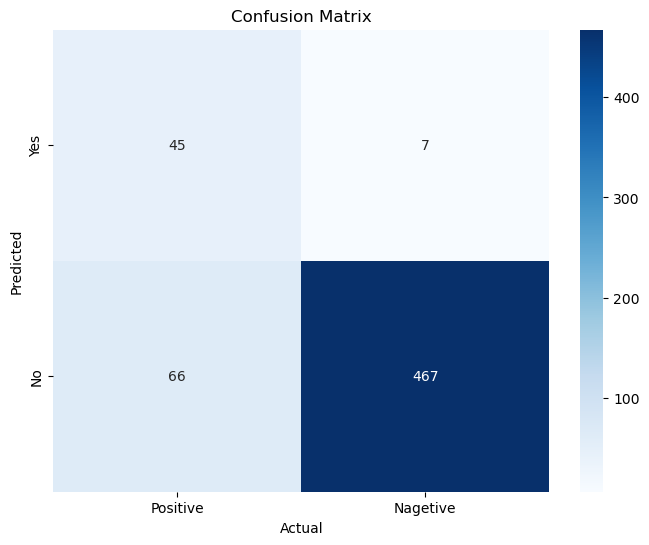

In [252]:
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [("Random Forest", confusion_matrix(y_test, y_pred))]
draw_confusion_matrices(confusion_matrices)

---

## 5.5 Further Analysis

In [206]:
def train_model(X_train, y_train, modelName):
    if modelName == "Dense Layer":
        model = Sequential()
        model.add(Dense(256, activation="relu"))
        model.add(Dense(10, activation = "softmax"))
        model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
        model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=2, validation_data=(X_test, y_test))
        
    elif modelName == "Random Forest":
        model = RandomForestClassifier(random_state = 123)
        model = model.fit(X_train, y_train)
        
    return model

In [232]:
def get_result(risk_df):
    risk_lst = np.unique(risk_df["Label 1"].values)
    i = 0
    for risk in risk_lst:
        new_df = generate_target_risk(riskName=risk, df=risk_df)
        X = np.array(avgVector_lst)
        y = new_df["Target Risk"].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 123, stratify = y)
        model = train_model(X_train, y_train, modelName = "Random Forest")
        y_pred = model.predict(X_test)
        
        if i == 0:
            predict = y_pred
        else:
            predict = np.vstack([predict, y_pred]) 
        i+=1
                                
    predict = predict.T
    return predict

In [234]:
predict_arr = get_result(risk_df)
print("There are", len(predict_arr), "test records.\n")
print("There are", len(predict_arr[0]), "risks.\n")

There are 585 test records.

There are 10 risks. 

